<a href="https://colab.research.google.com/github/ryanzhao29/Jax/blob/main/gpt_jax_fnished_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [8]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-06-19 10:19:50--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.7’

input.txt.7         100%[===================>]   1.06M  --.-KB/s    in 0.08s   

2024-06-19 10:19:51 (14.0 MB/s) - ‘input.txt.7’ saved [1115394/1115394]



In [9]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [10]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [11]:
# let's look at the first 1000 characters
# print(text[:1000])

In [12]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [13]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [115]:
import jax
from jax import vmap, jit
import jax.numpy as jnp
import flax.linen as nn
import flax
import optax
import copy

In [15]:
# Let's now split up the data into train and validation sets
 # first 90% will be train, rest val

data = jnp.array(encode(text), dtype=jnp.int32)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [16]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [17]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [18]:
seed = 1
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?

def get_batch(split, key):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = jax.random.randint(key, (batch_size,), 0, len(data) - block_size)
    x = jnp.stack([data[i:i+block_size] for i in ix])
    y = jnp.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
xb, yb = get_batch('train', subkey)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is context the target: {context.tolist(), target.tolist()}")


inputs:
(64, 32)
[[46 63  1 ... 52 43  8]
 [57 46 39 ... 43  1 43]
 [56 52  5 ... 57 43 52]
 ...
 [ 1 51 63 ... 52 42  1]
 [60 43  1 ...  1 41 46]
 [53  1 58 ...  1 39 52]]
targets:
(64, 32)
[[63  1 57 ... 43  8  0]
 [46 39 50 ...  1 43 39]
 [52  5 42 ... 43 52 42]
 ...
 [51 63  1 ... 42  1 42]
 [43  1 58 ... 41 46 53]
 [ 1 58 46 ... 39 52 42]]
----


In [19]:
print(xb) # our input to the transformer

[[46 63  1 ... 52 43  8]
 [57 46 39 ... 43  1 43]
 [56 52  5 ... 57 43 52]
 ...
 [ 1 51 63 ... 52 42  1]
 [60 43  1 ...  1 41 46]
 [53  1 58 ...  1 39 52]]


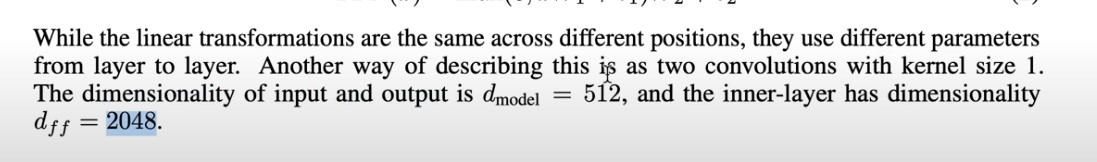

There is a multiplier of 4 from 512 to 2048

In [140]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
learning_rate = 3e-4
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

training = True

class Head(nn.Module):
  head_size: int
  train: bool
  dropout: float = 0.2
  @nn.compact
  def __call__(self, x):
    k = nn.Dense(self.head_size, use_bias=False)(x) # B, H, C
    q = nn.Dense(self.head_size,use_bias=False)(x)
    v = nn.Dense(self.head_size, use_bias=False)(x)
    wei = vmap(lambda x, y: jnp.matmul(x, y.transpose()), in_axes =(0,0))(q, k)  # B, H, H
    wei = jnp.tril(wei) / jnp.sqrt(self.head_size)
    mask = wei == 0
    wei = jnp.where(mask, -jnp.inf, wei)
    wei = jax.nn.softmax(wei)
    wei = nn.Dropout(rate=self.dropout, deterministic =not self.train)(wei)
    return vmap(lambda x, y: jnp.matmul(x, y), in_axes=(0,0))(wei, v) # B, H, C


class MultiHeadAttention(nn.Module):
  num_heads: int
  head_size: int
  embedding_size: int
  train: bool
  dropout: float = 0.2
  @nn.compact
  def __call__(self, x):
    output = Head(self.head_size, self.train)(x)
    for i in range(self.num_heads):
      output = jnp.concatenate((output, Head(self.head_size, self.train)(x)),axis=-1)
    # Change the shape for residual connection.
    output = nn.Dense(self.embedding_size)(output)
    output = nn.Dropout(rate=self.dropout, deterministic =not self.train)(output)
    return output

class FeedForward(nn.Module):
  model_size: int
  train: bool
  dropout: float = 0.2
  @nn.compact
  def __call__(self, x):
    # 4 is from the paper, see the image above.
    x = nn.Dense(4 * self.model_size, use_bias=False)(x)
    x = nn.relu(x)
    # Change the shape for residual connection.
    x = nn.Dense(self.model_size, use_bias=False)(x)
    x = nn.Dropout(rate=self.dropout, deterministic =not self.train)(x)
    return x

class Block(nn.Module):
  embedding_size: int
  head_size: int
  train: bool
  @nn.compact
  def __call__(self, x):
    x = nn.LayerNorm(self.embedding_size)(x)
    x = x + MultiHeadAttention(num_heads=self.head_size, head_size=self.embedding_size//self.head_size, embedding_size=self.embedding_size, train=self.train)(x)
    x = nn.LayerNorm(self.embedding_size)(x)
    x = x + FeedForward(self.embedding_size, self.train)(x)
    return x

class BigramLanguageModel(nn.Module):
  embedding_size: int
  vocab_size: int
  block_size: int
  head_size: int
  layer_size: int
  train: bool
  @nn.compact
  def __call__(self, x):
    content_emb = nn.Embed(self.vocab_size,self.embedding_size)(x)
    position_emb = nn.Embed(self.block_size, self.embedding_size)(jnp.arange(x.shape[1]))
    output = content_emb + position_emb
    for i in range(self.layer_size):
      output = Block(self.embedding_size, self.head_size, self.train)(output)

    output = nn.LayerNorm(self.embedding_size)(output)

    logits = nn.Dense(self.vocab_size)(output)
    return logits

  def loss(self, params, x, y, dropout_key):
    logits = self.apply(params, x, rngs={"dropout":dropout_key})
    # print(y.shape)
    # print(logits.shape)
    y = y.reshape(-1)
    B, T, C = logits.shape
    logits_reshaped = logits.reshape(B*T, C)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits_reshaped, y)
    loss = jnp.mean(loss)
    return loss

  def generate(self, params, idx, max_new_tokens, key):
    # idx is b x t.
    for _ in range(max_new_tokens):
      key, subkey = jax.random.split(key)
      idx_cond = jnp.expand_dims(idx[:, -self.block_size], axis=1)

      logits = self.apply(params, idx_cond)
      logits = logits[:,-1,:]
      idx_next = jax.random.categorical(subkey, logits, axis=1)

      idx_next = jnp.expand_dims(idx_next, axis=0)
      idx = jnp.concatenate((idx, idx_next), axis=1)
    return idx

model = BigramLanguageModel(embedding_size = n_embd,  vocab_size = vocab_size,  block_size = block_size, head_size = n_head, layer_size=n_layer, train=True)
key, subkey, init_key = jax.random.split(key, 3)
params = model.init(init_key, xb)
loss = model.loss(params, xb, yb, subkey)
print("loss is")
print(loss)
idx = jnp.ones((1, 1), dtype=jnp.int32)
# print(decode(model.generate(params, idx, max_new_tokens=100, key=subkey)[0].tolist()))

loss is
4.1742897


In [141]:
opt = optax.adam(learning_rate=1e-3)
opt_state = opt.init(params)
seed = 1
key = jax.random.PRNGKey(seed)
key, dropout_key = jax.random.split(key)

for epoch in range(100):
  key, sample_key,  = jax.random.split(key)
  xb, yb = get_batch('train', sample_key)
  dropout_key = jax.random.fold_in(dropout_key, epoch)
  loss, grads = jax.value_and_grad(model.loss)(params, xb, yb, dropout_key)
  updates, opt_state = opt.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if epoch % 50 == 0:
    print(f"epoch {epoch}, loss {loss}")

epoch 0, loss 4.174302101135254
epoch 50, loss 3.355424404144287


In [ ]:
print(decode(model.generate(params, idx, max_new_tokens=500, key=key)[0].tolist()))

## The mathematical trick in self-attention

In [ ]:
key, subkey = jax.split(key)
B, T, C = 4, 8, 2
x = jax.random.normal(subkey, (B, T, C))
print(x.shape)

AttributeError: module 'jax' has no attribute 'split'